In [1]:
!pip install tensorflow
!pip install xgboost

     |████████████████████████████████| 458.3 MB 13 kB/s              
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 462 kB 44.9 MB/s            
     |████████████████████████████████| 132 kB 64.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 65 kB 5.6 MB/s             
     |████████████████████████████████| 1.3 MB 51.8 MB/s            
     |████████████████████████████████| 42 kB 133 kB/s             
     |████████████████████████████████| 4.6 MB 42.2 MB/s            
     |████████████████████████████████| 5.6 MB 47.1 MB/s            
     |████████████████████████████████| 781 kB 46.2 MB/s            
     |████████████████████████████████| 4.9 MB 51.1 MB/s            
     |████████████████████████████████| 97 kB 10.4 MB/s            
     |████████████████████████████████| 152 kB 69.9 MB/s            
     |████████████████████████████████| 155 kB 76.6 MB/s            
     |████████████████

     |████████████████████████████████| 173.6 MB 12 kB/s              


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pyarrow

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

In [2]:
#### Functions to define the layers of the networks used in the 'define_models' functions below
    
def generator_network(x, data_dim, base_n_count): 
    x = layers.Dense(base_n_count, activation='relu')(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x)
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    x = layers.Dense(data_dim)(x)    
    return x
    
def generator_network_w_label(x, labels, data_dim, label_dim, base_n_count): 
    x = layers.concatenate([x,labels])
    x = layers.Dense(base_n_count*1, activation='relu')(x) # 1
    x = layers.Dense(base_n_count*2, activation='relu')(x) # 2
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    x = layers.Dense(data_dim)(x)    
    x = layers.concatenate([x,labels])
    return x
    
def discriminator_network(x, data_dim, base_n_count):
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    # x = layers.Dense(1)(x)
    return x
    
def critic_network(x, data_dim, base_n_count):
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x) # 2
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*1, activation='relu')(x) # 1
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(1, activation='sigmoid')(x)
    x = layers.Dense(1)(x)
    return x

In [3]:
def BaseMetrics(y_pred,y_true):
    TP = np.sum( (y_pred == 1) & (y_true == 1) )
    TN = np.sum( (y_pred == 0) & (y_true == 0) )
    FP = np.sum( (y_pred == 1) & (y_true == 0) )
    FN = np.sum( (y_pred == 0) & (y_true == 1) )
    return TP, TN, FP, FN

def SimpleMetrics(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    
    # Reporting
    from IPython.display import display
    print( 'Confusion Matrix')
    display( pd.DataFrame( [[TN,FP],[FN,TP]], columns=['Pred 0','Pred 1'], index=['True 0', 'True 1'] ) )
    print( 'Accuracy : {}'.format( ACC ))
    
def SimpleAccuracy(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    return ACC

In [4]:
def CheckAccuracy( x, g_z, data_cols, label_cols=[], seed=0, with_class=False, data_dim=2 ):

    # Slightly slower code to create dataframes to feed into the xgboost dmatrix formats
    
    # real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    # gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    # real_samples['syn_label'] = 0
    # gen_samples['syn_label'] = 1
    
    # training_fraction = 0.5
    # n_real, n_gen = int(len(real_samples)*training_fraction), int(len(gen_samples)*training_fraction)
    # train_df = pd.concat([real_samples[:n_real],gen_samples[:n_gen]],axis=0)
    # test_df = pd.concat([real_samples[n_real:],gen_samples[n_gen:]],axis=0)

    # X_col = test_df.columns[:-1]
    # y_col = test_df.columns[-1]
    # dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    # dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
    # y_true = test_df['syn_label']

    dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] ) # Use half of each real and generated set for training
    dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] ) # synthetic labels
    dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] ) # Use the other half of each set for testing
    y_true = dlabels # Labels for test samples will be the same as the labels for training samples, assuming even batch sizes
    
    dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols+label_cols)
    dtest = xgb.DMatrix(dtest, feature_names=data_cols+label_cols)
    
    xgb_params = {
        # 'tree_method': 'hist', # for faster evaluation
        'max_depth': 4, # for faster evaluation
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'auc', # allows for balanced or unbalanced classes 
        }
    xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for faster evaluation

    y_pred = np.round(xgb_test.predict(dtest))

    # return '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) # assumes balanced real and generated datasets
    return SimpleAccuracy(y_pred, y_true) # assumes balanced real and generated datasets

In [5]:
def PlotData( x, g_z, data_cols, label_cols=[], seed=0, with_class=False, data_dim=2, save=False, prefix='' ):
    
    real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    if with_class:
        axarr[0].scatter( real_samples[data_cols[0]], real_samples[data_cols[1]], c=real_samples[label_cols[0]]/2 ) #, cmap='plasma'  )
        axarr[1].scatter( gen_samples[ data_cols[0]], gen_samples[ data_cols[1]], c=gen_samples[label_cols[0]]/2 ) #, cmap='plasma'  )
        
        # For when there are multiple one-hot encoded label columns
        # for i in range(len(label_cols)):
            # temp = real_samples.loc[ real_samples[ label_cols[i] ] == 1 ]
            # axarr[0].scatter( temp[data_cols[0]], temp[data_cols[1]], c='C'+str(i), label=i )
            # temp = gen_samples.loc[ gen_samples[ label_cols[i] ] == 1 ]
            # axarr[1].scatter( temp[data_cols[0]], temp[data_cols[1]], c='C'+str(i), label=i )
        
    else:
        axarr[0].scatter( real_samples[data_cols[0]], real_samples[data_cols[1]]) #, cmap='plasma'  )
        axarr[1].scatter( gen_samples[data_cols[0]], gen_samples[data_cols[1]]) #, cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[1].set_title('generated')   
    axarr[0].set_ylabel(data_cols[1]) # Only add y label to left plot
    for a in axarr: a.set_xlabel(data_cols[0]) # Add x label to both plots
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim()) # Use axes ranges from real data for generated data
    
    if save:
        plt.save( prefix + '.xgb_check.png' )
        
    plt.show()


In [6]:
def get_data_batch(train, batch_size, seed=0):
    # # random sampling - some samples will have excessively low or high sampling, but easy to implement
    # np.random.seed(seed)
    # x = train.loc[ np.random.choice(train.index, batch_size) ].values
    
    # iterate through shuffled indices, so every sample gets covered evenly
    start_i = (batch_size * seed) % len(train)
    stop_i = start_i + batch_size
    shuffle_seed = (batch_size * seed) // len(train)
    np.random.seed(shuffle_seed)
    train_ix = np.random.choice( list(train.index), replace=False, size=len(train) ) # wasteful to shuffle every time
    train_ix = list(train_ix) + list(train_ix) # duplicate to cover ranges past the end of the set
    x = train.loc[ train_ix[ start_i: stop_i ] ].values
    
    return np.reshape(x, (batch_size, -1) )

In [7]:
#### Functions to define the keras network models    
    
def define_models_GAN(rand_dim, data_dim, base_n_count, type=None):
    generator_input_tensor = layers.Input(shape=(rand_dim, ))
    generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

    generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    
    if type == 'Wasserstein':
        discriminator_output = critic_network(generated_or_real_image_tensor, data_dim, base_n_count)
    else:
        discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim, base_n_count)

    generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
    discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
                                       outputs=[discriminator_output],
                                       name='discriminator')

    combined_output = discriminator_model(generator_model(generator_input_tensor))
    combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')
    
    return generator_model, discriminator_model, combined_model

def define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type=None):
    generator_input_tensor = layers.Input(shape=(rand_dim, ))
    labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
    generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

    generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class
    
    if type == 'Wasserstein':
        discriminator_output = critic_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count) # updated for class
    else:
        discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count) # updated for class

    generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
    discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
                                       outputs=[discriminator_output],
                                       name='discriminator')

    combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
    combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class
    
    return generator_model, discriminator_model, combined_model

In [8]:
#### Functions specific to the vanilla GAN architecture   

def training_steps_GAN(model_components):
    
    [ cache_prefix, with_class, starting_step,
                        train, data_cols, data_dim,
                        label_cols, label_dim,
                        generator_model, discriminator_model, combined_model,
                        rand_dim, nb_steps, batch_size, 
                        k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
                        data_dir, generator_model_path, discriminator_model_path, show,
                        combined_loss, disc_loss_generated, disc_loss_real, xgb_losses ] = model_components  
    
    for i in range(starting_step, starting_step+nb_steps):
        K.set_learning_phase(1) # 1 = train

        # train the discriminator
        for j in range(k_d):
            np.random.seed(i+j)
            z = np.random.normal(size=(batch_size, rand_dim))
            x = get_data_batch(train, batch_size, seed=i+j)
            
            if with_class:
                labels = x[:,-label_dim:]
                g_z = generator_model.predict([z, labels])
            else:
                g_z = generator_model.predict(z)
#             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
#             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
#             d_l_r = discriminator_model.train_on_batch(x, classes)
            
            d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
            d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
            # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
            # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
        disc_loss_real.append(d_l_r)
        disc_loss_generated.append(d_l_g)
        
        # train the generator
        for j in range(k_g):
            np.random.seed(i+j)
            z = np.random.normal(size=(batch_size, rand_dim))
            if with_class:
                # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
                loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
            else:
                # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
                loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
        combined_loss.append(loss)
        
        # Determine xgb loss each step, after training generator and discriminator
        if not i % 10: # 2x faster than testing each step...
            K.set_learning_phase(0) # 0 = test
            test_size = 492 # test using all of the actual fraud data
            x = get_data_batch(train, test_size, seed=i)
            z = np.random.normal(size=(test_size, rand_dim))
            if with_class:
                labels = x[:,-label_dim:]
                g_z = generator_model.predict([z, labels])
            else:
                g_z = generator_model.predict(z)
            xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
            xgb_losses = np.append(xgb_losses, xgb_loss)

        # Saving weights and plotting images
        if not i % log_interval:
            print('Step: {} of {}.'.format(i, starting_step + nb_steps))
            K.set_learning_phase(0) # 0 = test
                        
            # loss summaries      
            print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
            print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )            
            # print('Generator model loss: {}.'.format(combined_loss[-1]))
            # print('Discriminator model loss gen: {}.'.format(disc_loss_generated[-1]))
            # print('Discriminator model loss real: {}.'.format(disc_loss_real[-1]))
            # print('xgboost accuracy: {}'.format(xgb_losses[-1]) )
            
            if show:
                PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim, 
                            save=False, prefix= data_dir + cache_prefix + '_' + str(i) )
            
            # save model checkpoints
            model_checkpoint_base_name = data_dir + cache_prefix + '_{}_model_weights_step_{}.h5'
            generator_model.save_weights(model_checkpoint_base_name.format('generator', i))
            discriminator_model.save_weights(model_checkpoint_base_name.format('discriminator', i))
            pickle.dump([combined_loss, disc_loss_generated, disc_loss_real, xgb_losses], 
                open( data_dir + cache_prefix + '_losses_step_{}.pkl'.format(i) ,'wb'))
    
    return [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses]

In [46]:
def adversarial_training_GAN_1(arguments, train, data_cols, label_cols=[], seed=None, starting_step=0):
    
    if seed==None:
        seed=np.random.randint(1000)
    
    [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ] = arguments
    
    np.random.seed(seed)     # set random seed
    
    data_dim = len(data_cols)
    print('data_dim: ', data_dim)
    print('data_cols: ', data_cols)
    
    label_dim = 0
    with_class = False
    if len(label_cols) > 0: 
        with_class = True
        label_dim = len(label_cols)
        print('label_dim: ', label_dim)
        print('label_cols: ', label_cols)
    
    # define network models
    
    K.set_learning_phase(1) # 1 = train
    
    if with_class:
        cache_prefix = 'CGAN'
        generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
    else:
        cache_prefix = 'GAN'
        generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
    
    # compile models

    adam = Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9)

    generator_model.compile(optimizer=adam, loss='binary_crossentropy')
    discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
    discriminator_model.trainable = False
    combined_model.compile(optimizer=adam, loss='binary_crossentropy')
    
    if show:
        print(generator_model.summary())
        print(discriminator_model.summary())
        print(combined_model.summary())

    combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []
    
    if loss_pickle_path:
        print('Loading loss pickles')
        [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(open(loss_pickle_path,'rb'))
    if generator_model_path:
        print('Loading generator model')
        generator_model.load_weights(generator_model_path, by_name=True)
    if discriminator_model_path:
        print('Loading discriminator model')
        discriminator_model.load_weights(discriminator_model_path, by_name=True)

    model_components = [ cache_prefix, with_class, starting_step,
                        train, data_cols, data_dim,
                        label_cols, label_dim,
                        generator_model, discriminator_model, combined_model,
                        rand_dim, nb_steps, batch_size, 
                        k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
                        data_dir, generator_model_path, discriminator_model_path, show,
                        combined_loss, disc_loss_generated, disc_loss_real, xgb_losses ]
        
    [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = training_steps_GAN(model_components)

In [10]:
df_usuarios = pd.read_parquet(os.getcwd() + '/Data/Base_One_Hot_Encoding/base_one_hot_encoding.parquet')

In [92]:
# reloading the libraries and setting the parameters


# import GAN_171103
# import importlib
# importlib.reload(GAN_171103) # For reloading after making changes
# from GAN_171103 import *

rand_dim = 438 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = df_usuarios.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'fraude_general' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

In [ ]:
# !pip install --force-reinstall -v "tensorflow==2.0.4"
# !pip install --force-reinstall -v "keras==2.0.4"

In [12]:
from tensorflow.keras.optimizers import Adam

In [14]:
!pip install keras

In [16]:
import GAN_171103
import importlib
importlib.reload(GAN_171103) # For reloading after making changes
from GAN_171103 import *

In [93]:
data_cols=["p2p_cash_in","numero_de_referidos"]+pd.Series(data_cols)[list(~pd.Series(data_cols).isin(["p2p_cash_in","numero_de_referidos"]))].tolist()

In [94]:
train=pd.concat([train[data_cols],train[label_cols]],axis=1)

data_dim:  438
data_cols:  ['p2p_cash_in', 'numero_de_referidos', 'corresp_cashout', 'more_than_2_accounts', 'num_p2p_users', 'pct_mean_withd', 'cajero_cashout', 'pct_balance_min', 'numero_rechazadas', 'numero_sospechas', 'pocket_goals_count', 'pct_mean_withd_caj', 'tran_seq_750000_7_0.1', 'pse_cashin', 'more_than_2_emails', 'time_diff_tran_norm_den', 'more_than_2_phones', 'user_is_pep', 'visa_currency_first_category_ARS', 'visa_currency_first_category_AUD', 'visa_currency_first_category_BOB', 'visa_currency_first_category_BRL', 'visa_currency_first_category_CAD', 'visa_currency_first_category_CLP', 'visa_currency_first_category_COP', 'visa_currency_first_category_DOP', 'visa_currency_first_category_EUR', 'visa_currency_first_category_GBP', 'visa_currency_first_category_ILS', 'visa_currency_first_category_JPY', 'visa_currency_first_category_MAD', 'visa_currency_first_category_MXN', 'visa_currency_first_category_PEN', 'visa_currency_first_category_PYG', 'visa_currency_first_category_TRY

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 0 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0010, 0.6257, 0.8686, 1.0000
D Real - D Gen: 0.2429


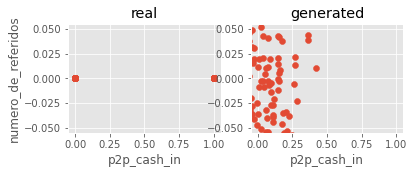

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 1.7417, 0.4643, 0.3511, 1.0000
D Real - D Gen: -0.1131


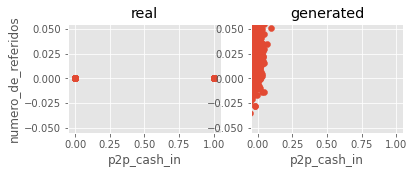

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 4.2544, 0.0453, 0.4565, 0.9980
D Real - D Gen: 0.4112


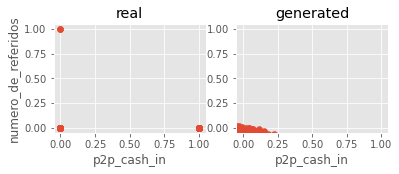

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 6.4545, 0.0320, 0.0895, 0.9980
D Real - D Gen: 0.0575


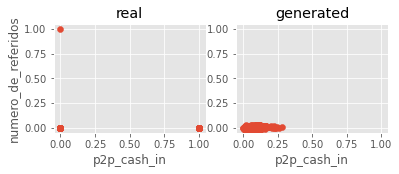

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 5.6854, 0.0107, 0.1974, 1.0000
D Real - D Gen: 0.1868


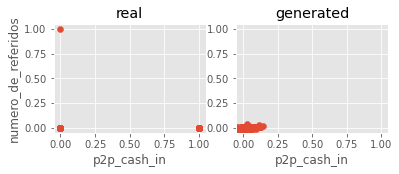

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 7.1276, 0.0058, 0.2589, 0.9959
D Real - D Gen: 0.2531


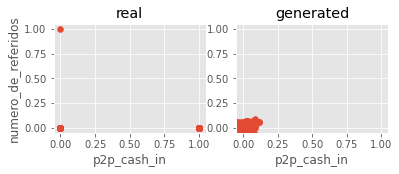

data_dim:  438
data_cols:  ['p2p_cash_in', 'numero_de_referidos', 'corresp_cashout', 'more_than_2_accounts', 'num_p2p_users', 'pct_mean_withd', 'cajero_cashout', 'pct_balance_min', 'numero_rechazadas', 'numero_sospechas', 'pocket_goals_count', 'pct_mean_withd_caj', 'tran_seq_750000_7_0.1', 'pse_cashin', 'more_than_2_emails', 'time_diff_tran_norm_den', 'more_than_2_phones', 'user_is_pep', 'visa_currency_first_category_ARS', 'visa_currency_first_category_AUD', 'visa_currency_first_category_BOB', 'visa_currency_first_category_BRL', 'visa_currency_first_category_CAD', 'visa_currency_first_category_CLP', 'visa_currency_first_category_COP', 'visa_currency_first_category_DOP', 'visa_currency_first_category_EUR', 'visa_currency_first_category_GBP', 'visa_currency_first_category_ILS', 'visa_currency_first_category_JPY', 'visa_currency_first_category_MAD', 'visa_currency_first_category_MXN', 'visa_currency_first_category_PEN', 'visa_currency_first_category_PYG', 'visa_currency_first_category_TRY

Step: 0 of 501.
Losses: G, D Gen, D Real, Xgb: 0.6695, 0.9609, 0.6383, 1.0000
D Real - D Gen: -0.3226


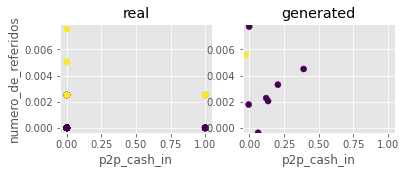

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 1.5669, 0.4418, 0.3848, 1.0000
D Real - D Gen: -0.0570


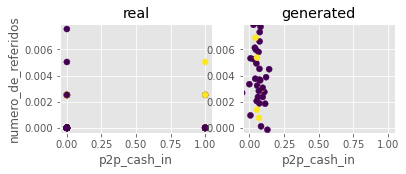

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 4.8640, 0.0659, 0.4738, 1.0000
D Real - D Gen: 0.4079


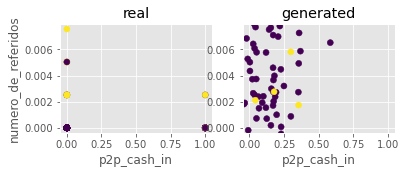

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 6.0545, 0.1555, 0.0239, 1.0000
D Real - D Gen: -0.1316


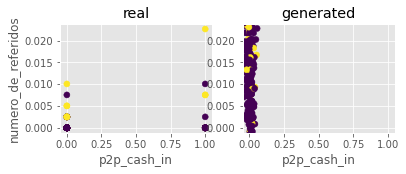

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 6.9237, 0.0078, 0.1391, 1.0000
D Real - D Gen: 0.1313


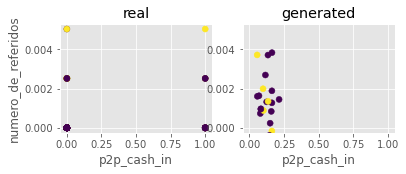

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 7.4384, 0.4201, 0.1157, 1.0000
D Real - D Gen: -0.3044


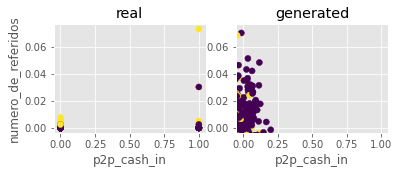

CPU times: user 4min 25s, sys: 12.9 s, total: 4min 38s
Wall time: 3min 15s


In [95]:
%%time

# Training the vanilla GAN and CGAN architectures

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN_1(arguments, train_no_label, data_cols ) # GAN
adversarial_training_GAN_1(arguments, train, data_cols=data_cols, label_cols=label_cols,seed=None) # CGAN

In [96]:
seed = 17

train = train.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'fraude_general' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0: with_class = True
np.random.seed(seed)

# define network models

# generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
# generator_model.load_weights('cache/WCGAN_generator_model_weights_step_4800.h5')
generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
generator_model.load_weights('cache/CGAN_generator_model_weights_step_500.h5')

In [102]:
# Now generate some new data

test_size = 100000 # Equal to all of the fraud cases

x = get_data_batch(train, test_size, seed=158)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)

1.0


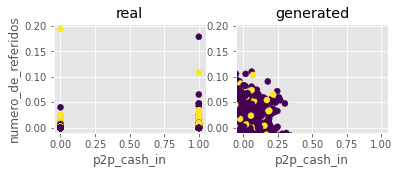

In [98]:
print( CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) )

PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )

In [128]:
test_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
data_real = pd.DataFrame(x, columns=data_cols+label_cols)

In [132]:
data_complete=pd.concat([data_real,test_samples[test_samples["fraude_general"]==1]])

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

In [142]:
training_fraction = 0.7

X=data_real[data_cols]
Y=data_real[label_cols]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1-training_fraction, random_state=128)

x_train=pd.concat([x_train,test_samples[test_samples["fraude_general"]==1][x_train.columns]])
y_train=pd.concat([y_train,test_samples[test_samples["fraude_general"]==1][["fraude_general"]]])

dtrain = xgb.DMatrix(x_train, y_train, feature_names=data_cols)
dtest = xgb.DMatrix(x_test, feature_names=data_cols)

In [144]:
xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 10,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100)

# y_pred = np.round(xgb_test.predict(dtest))

In [145]:
treshold=0.5
y_pred=[1 if i else 0 for i in xgb_test.predict(dtest)>treshold]

In [146]:
print( '{:.2f}'.format(SimpleAccuracy(np.array(y_pred), np.array(y_test["fraude_general"]))) )

0.96


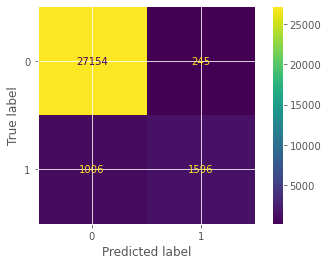

In [147]:
mat_2=confusion_matrix(np.array(y_test["fraude_general"]),y_pred)
ConfusionMatrixDisplay(mat_2).plot()

## probar el modelo solo con los datos originales

In [148]:
training_fraction = 0.7

X=data_real[data_cols]
Y=data_real[label_cols]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1-training_fraction, random_state=128)

dtrain = xgb.DMatrix(x_train, y_train, feature_names=data_cols)
dtest = xgb.DMatrix(x_test, feature_names=data_cols)

In [149]:
xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 10,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
}
xgb_test_1 = xgb.train(xgb_params, dtrain, num_boost_round=100)

# y_pred = np.round(xgb_test.predict(dtest))

In [150]:
treshold=0.5
y_pred=[1 if i else 0 for i in xgb_test_1.predict(dtest)>treshold]

In [151]:
print( '{:.2f}'.format(SimpleAccuracy(np.array(y_pred), np.array(y_test["fraude_general"]))) )

0.96


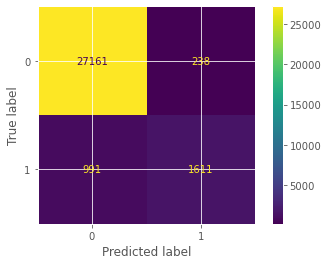

In [152]:
mat_2=confusion_matrix(np.array(y_test["fraude_general"]),y_pred)
ConfusionMatrixDisplay(mat_2).plot()

In [ ]:
%%time

# Training the WGAN and WCGAN architectures

k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN

In [17]:
df_usuarios["fraude_general"].value_counts()

0.00    190353
1.00     16801
Name: fraude_general, dtype: int64